# Introduction to Recommender Systems

## Learning Outcomes
* Differentiate between content-based and collaborative filtering methods.
* Explore model-based approaches for building recommender systems.

## Types of Recommender Systems
1. Content-Based Filtering
2. Collaborative Filtering
3. Model-Based Approaches

## Applications
* E-commerce: Product recommendations (e.g., Amazon, Takealot)
* Streaming Services: Movie or music recommendations (e.g., Netflix, Spotify)
* Social Media: Friend or content recommendations (e.g., Facebook, Twitter, Instagram)


![](https://miro.medium.com/v2/resize:fit:1400/1*bjNz3O2BZC2N3Y7k36fZHg.png)

# Imports and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

# Load the dataset
data = {
    'user_id': [1, 1, 1, 2, 2, 3, 3, 4],
    'item_id': [1, 2, 3, 1, 3, 2, 4, 1],
    'rating': [5, 3, 4, 4, 2, 5, 3, 2]
}
df = pd.DataFrame(data)
df

,user_id,item_id,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,2,1,4
4,2,3,2
5,3,2,5
6,3,4,3
7,4,1,2


### Basic EDA

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  8 non-null      int64
 1   item_id  8 non-null      int64
 2   rating   8 non-null      int64
dtypes: int64(3)
memory usage: 324.0 bytes


In [3]:
df.describe()

,user_id,item_id,rating
count,8.000000,8.000000,8.000000
mean,2.125000,2.125000,3.500000
std,1.125992,1.125992,1.195229
min,1.000000,1.000000,2.000000
25%,1.000000,1.000000,2.750000
50%,2.000000,2.000000,3.500000
75%,3.000000,3.000000,4.250000
max,4.000000,4.000000,5.000000


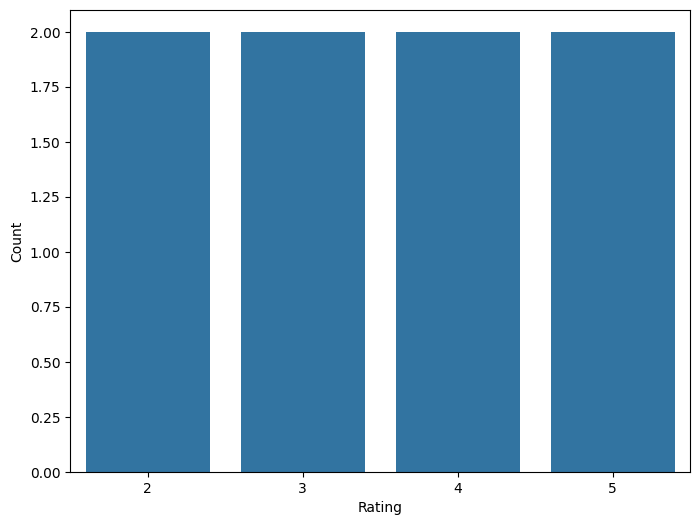

In [4]:
# @title Distribution of Ratings
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

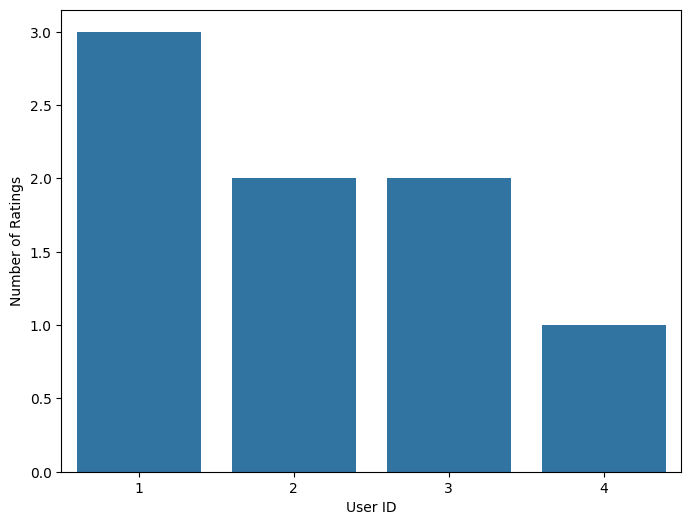

In [5]:
# @title Number of ratings per user
ratings_per_user = df['user_id'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
sns.barplot(x=ratings_per_user.index, y=ratings_per_user.values)
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.show()

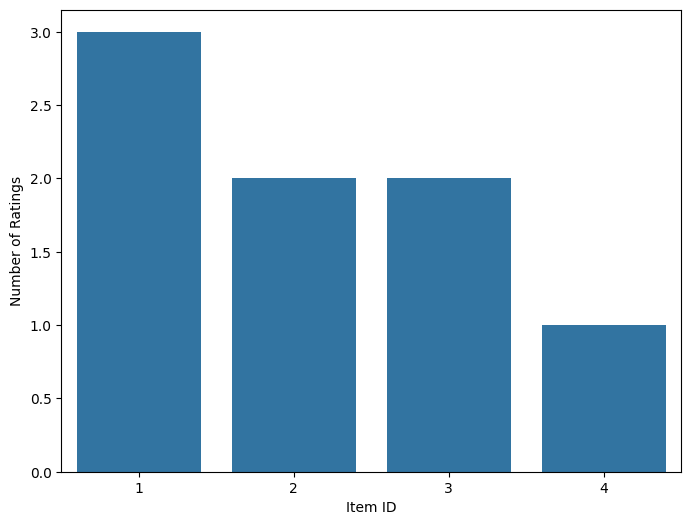

In [6]:
# @title Number of ratings per item
ratings_per_item = df['item_id'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
sns.barplot(x=ratings_per_item.index, y=ratings_per_item.values)
plt.xlabel('Item ID')
plt.ylabel('Number of Ratings')
plt.show()

In [7]:
items = {
    'item_id': [1, 2, 3, 4],
    'description': [
        "Action and adventure movie with lots of thrills",
        "Romantic comedy with a love story",
        "Science fiction with futuristic elements",
        "Animated film with fun characters"
    ]
}
items

{'item_id': [1, 2, 3, 4],
 'description': ['Action and adventure movie with lots of thrills',
  'Romantic comedy with a love story',
  'Science fiction with futuristic elements',
  'Animated film with fun characters']}

Every movie needs some sort of characteristics for matching

In [8]:
items_df = pd.DataFrame(items)

# Merge the ratings with item descriptions
df = pd.merge(df, items_df, on='item_id')
df.head()

,user_id,item_id,rating,description
0,1,1,5,Action and adventure movie with lots of thrills
1,1,2,3,Romantic comedy with a love story
2,1,3,4,Science fiction with futuristic elements
3,2,1,4,Action and adventure movie with lots of thrills
4,2,3,2,Science fiction with futuristic elements


## Time to NLP

In [9]:
# Create TF-IDF matrix for item descriptions
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(items_df['description'])

The TF-IDF matrix is created from the item descriptions, where each row represents an item and each column represents a term's TF-IDF value.

In [10]:
print(pd.DataFrame(tfidf_matrix.toarray(), index=items_df['item_id'], columns=tfidf_vectorizer.get_feature_names_out()))

          action  adventure      and  animated  characters    comedy  \
item_id                                                                
1        0.37082    0.37082  0.37082  0.000000    0.000000  0.000000   
2        0.00000    0.00000  0.00000  0.000000    0.000000  0.483803   
3        0.00000    0.00000  0.00000  0.000000    0.000000  0.000000   
4        0.00000    0.00000  0.00000  0.483803    0.483803  0.000000   

         elements   fiction      film       fun  futuristic     lots  \
item_id                                                                
1        0.000000  0.000000  0.000000  0.000000    0.000000  0.37082   
2        0.000000  0.000000  0.000000  0.000000    0.000000  0.00000   
3        0.483803  0.483803  0.000000  0.000000    0.483803  0.00000   
4        0.000000  0.000000  0.483803  0.483803    0.000000  0.00000   

             love    movie       of  romantic   science     story  thrills  \
item_id                                                 

# Content-Based Filtering
Content-based filtering recommends items similar to those a user has liked in the past. It uses item features and user profiles to make recommendations.

### Key Concepts:
* Item Profile: A set of features describing the item (e.g., genre, author).
* User Profile: A set of preferences based on the user's past interactions.

### Advantages:
* Doesn't require data on other users (works well for new items).
* Recommendations can be explained by item features.

### Disadvantages:
* Limited to known item features.
* Can't recommend items outside the user's existing preferences.

In [11]:
# @title Create a user profile
user_id = 1
user_ratings = df[df['user_id'] == user_id]

In [12]:
# @title Average the TF-IDF vectors for items the user has rated, weighted by their ratings
user_profile = np.dot(user_ratings['rating'], tfidf_matrix[user_ratings['item_id'] - 1].toarray())
user_profile

array([1.85410172, 1.85410172, 1.85410172, 0.        , 0.        ,
       1.45140776, 1.93521035, 1.93521035, 0.        , 0.        ,
       1.93521035, 1.85410172, 1.45140776, 1.85410172, 1.85410172,
       1.45140776, 1.93521035, 1.45140776, 1.85410172, 2.73482502])

![](https://images.deepai.org/glossary-terms/cosine-similarity-1007790.jpg)

![](https://www.machinelearningplus.com/wp-content/uploads/2018/10/soft-cosine.png)

In [13]:
# @title Calculate similarity between user profile and item profiles
similarities = cosine_similarity([user_profile], tfidf_matrix.toarray())
similarities

array([[0.72064327, 0.47205314, 0.59835625, 0.09314381]])

In [14]:
# @title Get top N recommendations
top_n = 3
recommended_item_indices = similarities.argsort()[0][-top_n:]
recommended_items = items_df.iloc[recommended_item_indices]

print("Content-Based Recommendations for User 1:")
print(recommended_items)

Content-Based Recommendations for User 1:
   item_id                                      description
1        2                Romantic comedy with a love story
2        3         Science fiction with futuristic elements
0        1  Action and adventure movie with lots of thrills


# Collaborative Filtering
Relies on user-item interactions (e.g., ratings) and makes recommendations based on similarities between users or items.

### Types:
1. User-Based Collaborative Filtering:
Finds users similar to the target user and recommends items they liked. Uses similarity measures like cosine similarity, Pearson correlation.
2. Item-Based Collaborative Filtering:
Finds items similar to those the target user has liked and recommends them. Similarity between items is calculated based on user ratings.


### Advantages:

* No need for detailed item features.
* Can discover new interests for users.

### Disadvantages:

* Suffers from the "cold start" problem (requires sufficient user interaction data).
* Scalability issues with large datasets.

### Example:
If user A and user B both liked similar movies, and user B liked a new movie that user A hasn't seen yet, the system will recommend that new movie to user A.

In [15]:
# @title Create user-item matrix
user_item_matrix = df.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)
user_item_matrix

item_id,1,2,3,4
user_id,,,,
1,5.0,3.0,4.0,0.0
2,4.0,0.0,2.0,0.0
3,0.0,5.0,0.0,3.0
4,2.0,0.0,0.0,0.0


In [16]:
# @title Calculate cosine similarity
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)
user_similarity_df

user_id,1,2,3,4
user_id,,,,
1,1.000000,0.885438,0.363803,0.707107
2,0.885438,1.000000,0.000000,0.894427
3,0.363803,0.000000,1.000000,0.000000
4,0.707107,0.894427,0.000000,1.000000


In [17]:
# @title Get top N recommendations for a user
def get_collaborative_recommendations(user_id, user_item_matrix, user_similarity_df, n=3):
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).index[1:]
    similar_users_ratings = user_item_matrix.loc[similar_users].mean()
    recommendations = similar_users_ratings.sort_values(ascending=False).index[:n]
    return recommendations


In [18]:
# @title Collaborative Filtering Recommendations for User 1

print(get_collaborative_recommendations(1, user_item_matrix, user_similarity_df))


Index([1, 2, 4], dtype='int64', name='item_id')


# Model-Based Approaches
Use machine learning techniques to predict user preferences. These methods build a model based on the training data and use it to make recommendations.

### Common Techniques:

1. Matrix Factorization (e.g., SVD, ALS): Decomposes the user-item interaction matrix into latent factors.
2. Deep Learning: Neural networks to capture complex patterns in data (e.g., autoencoders, deep collaborative filtering).

### Advantages:

* Can handle large datasets efficiently.
* Often provide better accuracy than heuristic methods.

### Disadvantages:

* Requires significant computational resources.
* May be complex to implement and interpret.

### Example:
Matrix factorization techniques can predict user ratings by learning latent factors representing users and items, which are then used to approximate the original user-item interaction matrix.

In [19]:
# @title Apply SVD
svd = TruncatedSVD(n_components=2)
user_item_matrix_svd = svd.fit_transform(user_item_matrix)

In [20]:
# @title Reconstruct the matrix
reconstructed_matrix = np.dot(user_item_matrix_svd, svd.components_)

In [21]:
# @title Get top N recommendations for a user
def get_svd_recommendations(user_id, reconstructed_matrix, n=3):
    user_ratings = reconstructed_matrix[user_id - 1]
    recommendations = np.argsort(user_ratings)[-n:]
    return recommendations

In [22]:
print("Model-Based Recommendations for User 1:", get_svd_recommendations(1, reconstructed_matrix))

Model-Based Recommendations for User 1: [1 2 0]


## Learning Outcomes
* Differentiate between content-based and collaborative filtering methods.
* Explore model-based approaches for building recommender systems.